# Unsupervised Learning Techniques

雖然今天機器學習的大部分應用都是基於監督學習（因此，這是大部分投資的方向），但絕大多數可用數據實際上是未標記的：我們有輸入特徵 X，但是 我們沒有標籤 y。

Yann LeCun famously said that “if intelligence was a cake, unsupervised learning would be the cake, supervised learning would be the icing on the cake, and reinforcement learning would be the cherry on the cake”. In other words, there is a huge potential in unsupervised learning that we have only barely started to sink our teeth into.

* Clustering

* Anomaly detection(outlier detection)

* Density estimation

# Setup

In [60]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.mixture import BayesianGaussianMixture

為了防止一些Sklearn更新的不必要警告:

In [2]:

# import warnings filter
from warnings import simplefilter
import warnings
#ugnore all future warnings
simplefilter(action='ignore', category=FutureWarning)

And let's create the images/unsupervised_learning folder (if it doesn't already exist), and define the save_fig() function which is used to save the figure

In [3]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "unsupervised_learning"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# K-means

我們使用blobs數據集

In [4]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

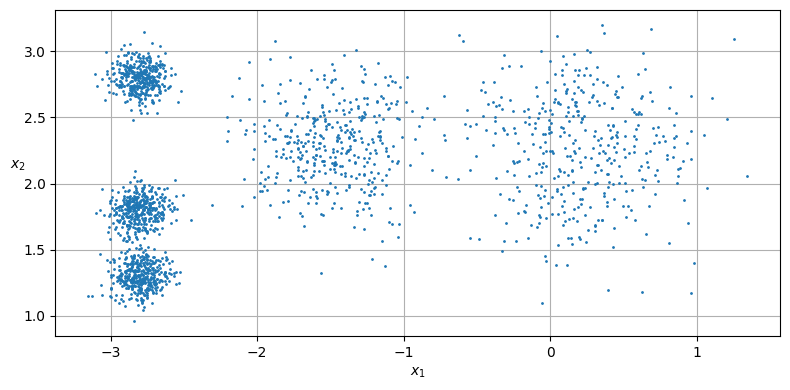

In [5]:
# extra code – the exact arguments of make_blobs() are not important
blob_centers = np.array([[ 0.2,  2.3], [-1.5 ,  2.3], [-2.8,  1.8],
                         [-2.8,  2.8], [-2.8,  1.3]])
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])
X, y = make_blobs(n_samples=2000, centers=blob_centers, cluster_std=blob_std,
                  random_state=7)

#how thw dataset look like
def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$", rotation=0)

plt.figure(figsize=(8, 4))
plot_clusters(X)
plt.gca().set_axisbelow(True)
plt.grid()
save_fig("blobs_plot")
plt.show()

In [6]:
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X)

每個observation都分配給 5 個集群之一：

In [7]:
y_pred

array([4, 0, 1, ..., 2, 1, 0])

observation的label是該observation被算法分配到的集群的索引：不要將其與分類中的類標籤混淆（請記住，聚類是一項無監督學習任務）。 KMeans保留了它所訓練實例的observation副本，可通過 labels_獲得(與y_pred是一樣的)：

In [8]:
kmeans.labels_

array([4, 0, 1, ..., 2, 1, 0])

我們還可以查看算法找到的 5 個centroids：

In [9]:
kmeans.cluster_centers_

array([[-2.80389616,  1.80117999],
       [ 0.20876306,  2.25551336],
       [-2.79290307,  2.79641063],
       [-1.46679593,  2.28585348],
       [-2.80037642,  1.30082566]])

輕鬆地將新observation分配給centroids最近的集群：

In [10]:
X_new = np.array([[0, 2], [3, 2], [-3, 3], [-3, 2.5]])
kmeans.predict(X_new)

array([1, 1, 2, 2])

繪製模型的決策邊界。

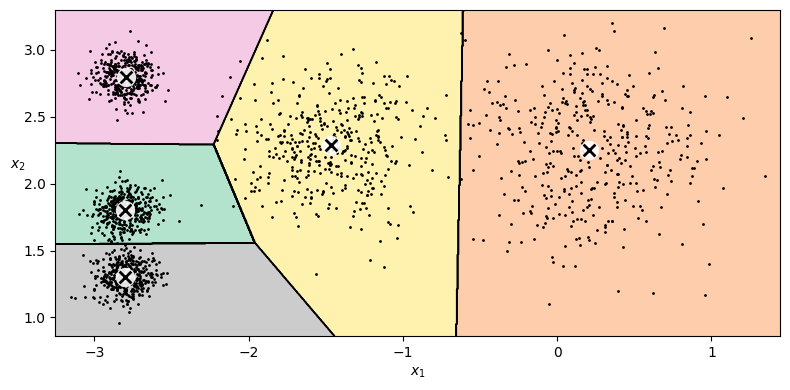

In [11]:
# extra code – this cell generates and saves Figure 9–3

def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$")
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", rotation=0)
    else:
        plt.tick_params(labelleft=False)

plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X)
save_fig("voronoi_plot")
plt.show()

群間距離圖顯示二維centroids的embedding，並保留與其他中心的距離。 observation在可視化中離中心越近，它們在原始特徵空間中的距離就越近。 默認情況下，它們按群中成員數量確定大小，例如屬於每個群的observation數。 這給出了集群的相對重要性的感覺。 但是請注意，因為兩個群在 2D 空間中重疊，並不意味著它們在原始特徵空間中重疊。

In [12]:
from yellowbrick.cluster import InterclusterDistance

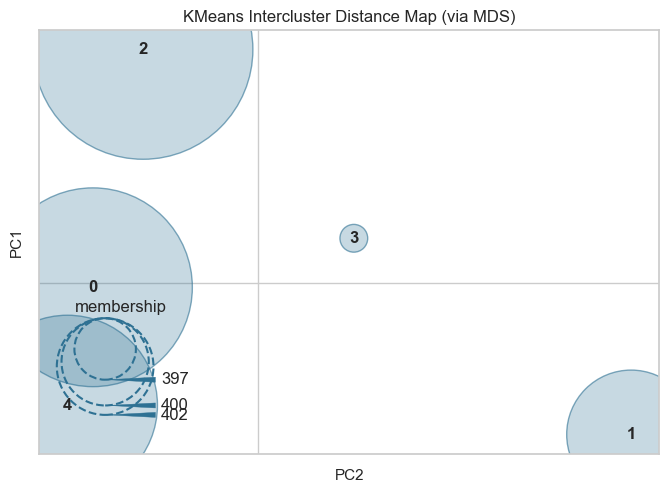

<Axes: title={'center': 'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [13]:
visualizer = InterclusterDistance(kmeans)

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

## hard clustering and soft clustering


將每個observation分配給一個單獨的集群，這被稱為hard clustering，而給每個observation相對於每隔集群一個分數可能很有用，這被稱為soft clustering。 例如，分數可以是observation和centroid之間的距離，或者相反它可以是相似度分數（或親和力affinity），例如Gaussian Radial Basis Function。

在 KMeans中， transform() 方法測量每個observation到每個centroid的距離：

In [14]:
kmeans.transform(X_new).round(2)

array([[2.81, 0.33, 2.9 , 1.49, 2.89],
       [5.81, 2.8 , 5.85, 4.48, 5.84],
       [1.21, 3.29, 0.29, 1.69, 1.71],
       [0.73, 3.22, 0.36, 1.55, 1.22]])

在此範例中，X_new 中的第一個observation與第一個centroid的距離約為 2.81，與第二個centroid的距離約為 0.33，依此類推。 

如果有一個高維數據集並以這種方式對其進行轉換，最終會得到一個 k 維數據集，這種轉換可以是非常有效的非線性降維技術。 或者，可以將這些距離用作額外特徵來訓練另一個模型(處理經緯度的時候可以這樣轉換)。

## Centroid initialization methods

不幸的是，雖然算法保證收斂，但它可能不會收斂到正確的解決方案（即，它可能收斂到局部最優），這取決於centroid initialization。

1. 如果碰巧知道centroid應該在哪裡（例如，如果之前運行了另一個聚類算法），那麼可以將 init 參數設置為包含質心列表的 NumPy 數組，並將 n_init 設置為 1：

In [15]:
good_init = np.array([[-3, 3], [-3, 2], [-3, 1], [-1, 2], [0, 2]])
kmeans = KMeans(n_clusters=5, init=good_init, n_init=1, random_state=42)
kmeans.fit(X)

KMeans(init=array([[-3,  3],
       [-3,  2],
       [-3,  1],
       [-1,  2],
       [ 0,  2]]),
       n_clusters=5, n_init=1, random_state=42)

2. 另一種解決方案是使用不同的隨機初始化多次運行算法並保留最佳解決方案。 這是由 n_init 參數控制的：默認情況下，它等於 10，這意味著當您調用 fit() 時，前面描述的整個算法實際上運行了 10 次，而 Scikit-Learn 保留了最佳解決方案。 但它究竟如何知道哪個解決方案是最好的呢？ 它使用performance metric！ 它被稱為model's inertia(慣性)：這是每個observation與其最近的centroid之間的均方距離。 KMeans運行算法 n_init 次並保持模型具有最低的慣性。

In [16]:
kmeans.inertia_

211.59853725816836

score() 方法返回負慣性。 (是負的是因為score() 方法必須始終遵守“越大越好”的規則。)

In [17]:
kmeans.score(X)

-211.59853725816836

3. David Arthur 和 Sergei Vassilvitskii 在 2006 年的一篇論文中提出了 K-Means 算法的一項重要改進，稱為 K-Means++。 他們引入了一個更智能的初始化步驟，傾向於選擇彼此遠離的centroid，並且 這使得 K-Means 算法更不太可能收斂到次優解。 他們表明，更智能的初始化步驟所需的額外計算是非常值得的，因為它可以大大減少算法需要運行以找到最佳解決方案的次數。 sklearn中的KMeans實際上預設使用這種初始化方法。 如果想強制它使用原始方法（即隨機選擇 k 個實例來定義初始質心），那麼你可以將 init 超參數設置為“random”，但幾乎根本沒必要這樣做。


## Accelerated K-means

Charles Elkan 在 2003 年的一篇論文中提出了對 K-Means 算法的另一項重要改進。 它通過避免許多不必要的距離計算大大加快了算法速度，這是通過利用三角不等式(即直線總是最短的) 並跟踪observation和centroid之間距離的下限和上限。 然而這種方式並不總是加速，有時還會減慢，取決於資料集。要使用此算法，將algorithm參數設為"elkan"(預設為"full"，是原本的算法)。

## mini-batch k-means

David Sculley 在 2010 年的一篇論文中提出了 K-Means 算法的另一個重要變體。該算法不是在每次迭代時使用完整數據集，而是能夠使用小批量，在每次迭代時稍微移動centroid。 這通常可以將算法速度提高 3 或 4 倍，並且可以對無法放入內存的龐大數據集進行聚類。 Scikit-Learn 在 MiniBatchKMeans中實現了這個算法，可以像使用 KMeans 類一樣使用：

In [18]:
from sklearn.cluster import MiniBatchKMeans

minibatch_kmeans = MiniBatchKMeans(n_clusters=5, random_state=42)
minibatch_kmeans.fit(X)

MiniBatchKMeans(n_clusters=5, random_state=42)

如果數據集不適合內存，最簡單的選擇是使用 memmap 。或者，可以一次將一個小批量傳遞給 partial_fit() 方法，但是這將需要更多的工作，因為將需要執行多個初始化並自己選擇最好的一個。 雖然 Mini-batch K-Means 算法比常規 KMeans 算法快得多，但它的慣性一般會稍差一些，尤其是隨著簇數的增加。 可以在下圖中看到這一點：左邊的圖比較了小批量 K-Means 和常規 K-Means 模型在數據集上使用不同數量的k 訓練的慣性。 然而，在右側的圖中，可以看到 Mini-batch K-Means 比常規 K-Means 快得多(將近3.5倍)，並且這種差異隨著 k 的增加而增加。

## Finding the optimal number of clusters

到目前為止，我們已將簇數 k 設置為 5，因為通過查看數據可以明顯看出這是正確的簇數。 但一般來說，知道如何設置 k 並不是那麼容易，如果設置錯誤，結果可能會很糟糕。

1. elbow法

在嘗試選擇 k 時，只選擇較低的慣性(inertia)不是一個好的性能指標，因為隨著我們增加 k，它會越來越低。 實際上，集群越多，每個observation就越接近其最近的centroid，因此慣性就越低。


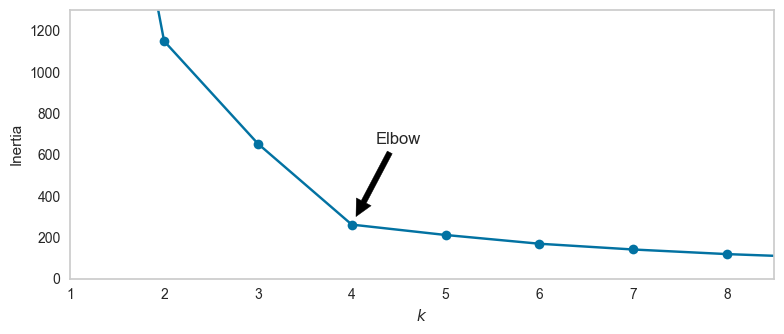

In [19]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$")
plt.ylabel("Inertia")
plt.annotate("", xy=(4, inertias[3]), xytext=(4.45, 650),
             arrowprops=dict(facecolor='black', shrink=0.1))
plt.text(4.5, 650, "Elbow", horizontalalignment="center")
plt.axis([1, 8.5, 0, 1300])
plt.grid()
save_fig("inertia_vs_k_plot")
plt.show()

當我們將 k 增加到 4 時，慣性下降得非常快，但隨著我們繼續增加 k，慣性下降得更慢。 這條曲線大致是手臂的形狀，並且在 k=4 處有一個“肘部(elbow)”，所以如果不知道更好的K數量，這將是一個不錯的選擇：任何較低的值都會很戲劇化，而任何較高的值都無濟於事 ，我們可能會無緣無故地將完美的集群分成兩半。

2. silhouette score法

然而elbow法這種為簇數選擇最佳值的技術相當粗糙。 一種更精確的方法（但計算成本也更高）是使用輪廓分數(silhouette score)，它是所有observation的平均輪廓係數(silhouette coefficient)。 一個observation的silhouette coefficient)等於 (b – a) / max(a, b)，其中 a 是此observation到同一集群中其他observation的平均距離（它是集群內的平均距離），b 是此observation到下一個最近集群的每個observation的平均距離。 silhouette score可以在 -1 和 +1 之間變化：接近 +1 的係數意味著該observation很好地位於它自己的集群內並且遠離其他集群，而接近 0 的係數意味著它靠近集群邊界， 最後一個接近 -1 的係數意味著該observation可能已被分配到錯誤的集群。 
要計silhouette score，可以使用 Scikit-Learn 的 silhou ette_score() 函數，為它提供數據集中的所有observation，以及為它們分配的集群標籤：

In [20]:
from sklearn.metrics import silhouette_score

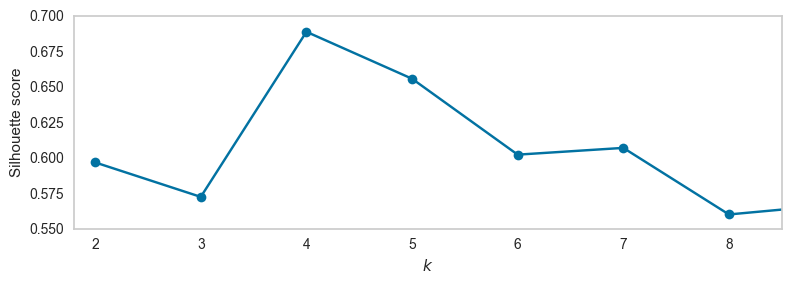

In [21]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X)
                for k in range(1, 10)]
silhouette_scores = [silhouette_score(X, model.labels_)
                     for model in kmeans_per_k[1:]]

plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$")
plt.ylabel("Silhouette score")
plt.axis([1.8, 8.5, 0.55, 0.7])
plt.grid()
save_fig("silhouette_score_vs_k_plot")
plt.show()

這個可視化比elbow法要豐富得多。特別是，雖然它確認 k=4 是一個很好的選擇，但它也強調了一個事實，即 k=5 也很好。這在只比較慣性時是看不到的。

### silhouette diagram

當繪製每個observation的silhouette coefficient時，可以獲得更多信息的可視化，按它們分配給的集群和係數值排序。這叫做silhouette diagram。

In [22]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter


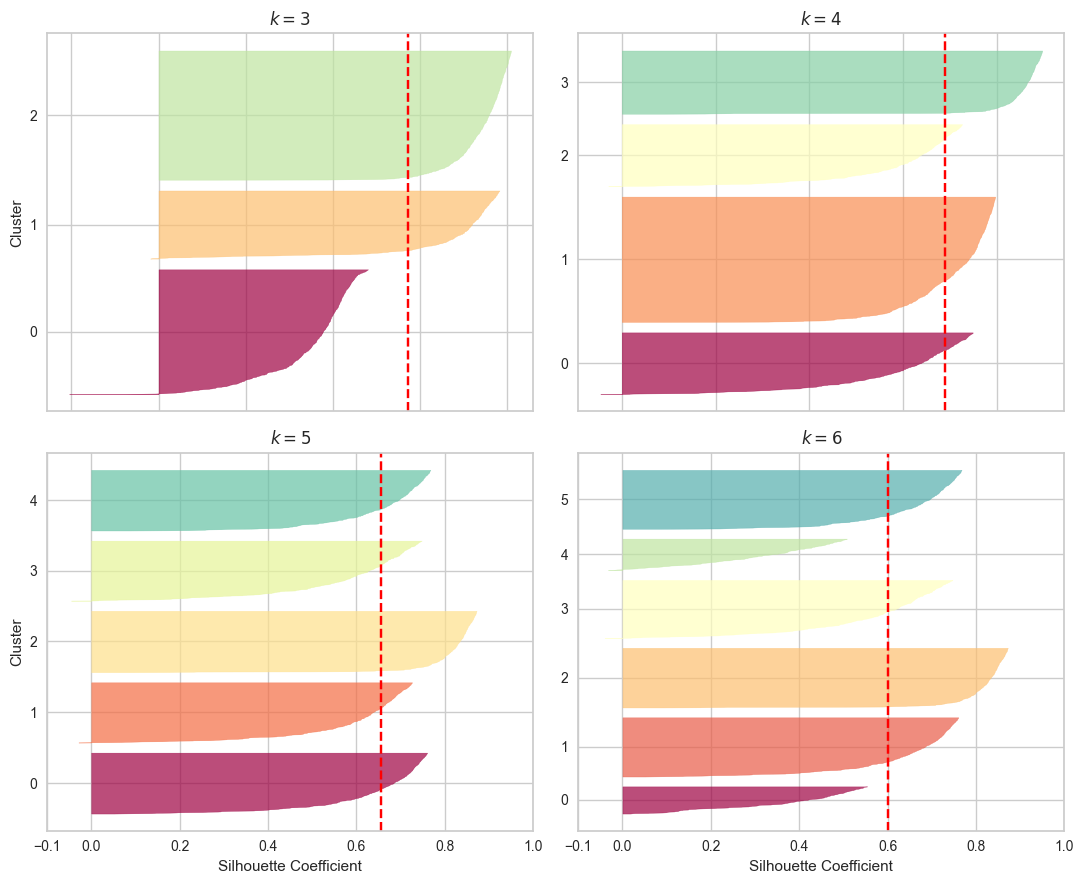

In [23]:

plt.figure(figsize=(11, 9))

for k in (3, 4, 5, 6):
    plt.subplot(2, 2, k - 2)
    
    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X, y_pred)

    padding = len(X) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = plt.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")
    
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title(f"$k={k}$")

save_fig("silhouette_analysis_plot")
plt.show()

刀形的高度表示簇中觀測值的個數，寬度表示簇中觀測值的silhouette coefficient（越寬越好）

我們可以看到，當 k=3 和 k=6 時，我們得到了壞簇。 但是當 k=4 或 k=5 時，集群看起來非常好，大多數observations超出虛線，向右延伸並接近 1.0。 當 k=4 時，索引 1（從頂部數第三個）處的聚類相當大，而當 k=5 時，所有聚類的大小都相似，因此即使 k=4 的整體silhouette score略高於 k=5，使用 k=5 來獲得相似大小的簇似乎是個好主意。

# Using Clustering for Image Segmentation

在顏色分割(color segmentation)中，具有相似顏色的像素被分配到同一segment。 這在許多應用中就足夠了。 例如，如果想分析衛星圖像以測量一個區域中有多少森林總面積，顏色分割可能就很好。

在語義分割(semantic segmentation)中，屬於同一對像類型的所有像素都被分配到同一segment。 例如，在自動駕駛汽車的視覺系統中，屬於行人圖像一部分的所有像素都可能分配給“行人”部分（將有一個segment包含所有行人）。

在實例分割(instance segmentation)中，屬於同一individual object的所有像素都被分配給同一segment 在這種情況下，每個行人都有不同的segment。

# Using Clustering for Semi-Supervised Learning

Another use case for clustering is in semi-supervised learning, when having plenty of unlabeled instances and very few labeled observations. 

用一個很像 Mnist dataset的資料集試試看，任務是辨別手寫數字

In [24]:
from sklearn.datasets import load_digits

X_digits, y_digits = load_digits(return_X_y=True)
X_train, y_train = X_digits[:1400], y_digits[:1400]
X_test, y_test = X_digits[1400:], y_digits[1400:]

假裝只有前50個observation有標籤能用，並用羅基斯回歸獲得初始模型的baseline performance

In [27]:
from sklearn.linear_model import LogisticRegression

n_labeled = 50
log_reg = LogisticRegression(max_iter=10_000)
log_reg.fit(X_train[:n_labeled], y_train[:n_labeled])

log_reg.score(X_test, y_test)#test set 是一定要有標籤的

0.7481108312342569

因為能用的訓練資料太少又不精，Accuracy只有0.75左右

看看怎樣能更好

首先，將訓練集創建為 50 個集群。 然後對於每個簇，找到最接近centroid的圖像。 這些圖像稱為代representative images。

In [28]:
k = 50
kmeans = KMeans(n_clusters=k, random_state=42)
X_digits_dist = kmeans.fit_transform(X_train)
representative_digit_idx = X_digits_dist.argmin(axis=0)
X_representative_digits = X_train[representative_digit_idx]

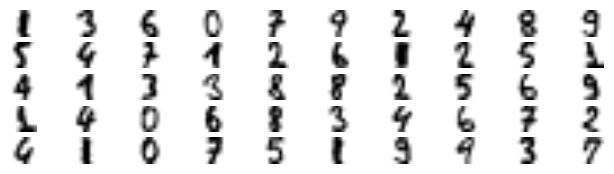

In [31]:
#50 representative images:
plt.figure(figsize=(8, 2))
for index, X_representative_digit in enumerate(X_representative_digits):
    plt.subplot(k // 10, 10, index + 1)
    plt.imshow(X_representative_digit.reshape(8, 8), cmap="binary",
               interpolation="bilinear")
    plt.axis('off')


現在要手動標記他們

In [32]:
y_representative_digits = np.array([
    1, 3, 6, 0, 7, 9, 2, 4, 8, 9,
    5, 4, 7, 1, 2, 6, 1, 2, 5, 1,
    4, 1, 3, 3, 8, 8, 2, 5, 6, 9,
    1, 4, 0, 6, 8, 3, 4, 6, 7, 2,
    4, 1, 0, 7, 5, 1, 9, 9, 3, 7
])

現在我們有一個只有 50 個標記observation的數據集，但不是隨機observation，每個observation都是其集群的代表性圖像。

看看模型能否表現更好

In [33]:
log_reg = LogisticRegression(max_iter=10_000)
log_reg.fit(X_representative_digits, y_representative_digits)
log_reg.score(X_test, y_test)

0.8488664987405542

同樣只用50筆資料學習，但是因為是更好的資料(具代表性資料)，資料品質提升，模型表現好很多。 雖然要手動標記，可能還需要起專家標記等等。

* label propagation

如果將標籤傳播到同一集群中的所有其他observation會怎樣？這叫做label propagation

In [36]:
kmeans.labels_

array([32, 41, 39, ..., 40, 40, 43])

In [41]:
len(X_train)

1400

In [37]:
y_train_propagated = np.empty(len(X_train), dtype=np.int64)#初始化長度與 X_train 相同的空 NumPy 陣列 y_train_propagated ，以存儲傳播的標籤。
for i in range(k):#反覆運算範圍為 k ，其中 k 表示聚類數
    y_train_propagated[kmeans.labels_ == i] = y_representative_digits[i]#將代表性標籤 y_representative_digits[i] 分配給 y_train_propagated 中的相應數據點，
    #其中 kmeans.labels_ 等於 i 。它實質上是將每個聚類的代表性標籤分配給該聚類中的所有數據點。

再訓練一次模型

In [40]:
log_reg = LogisticRegression(max_iter=10_000)
log_reg.fit(X_train, y_train_propagated)
log_reg.score(X_test, y_test)

0.8942065491183879

表現更好了，因為在標籤傳播後，每個observation都有標籤了，使用了全部1400個訓練數據

讓我們看看我們是否可以通過忽略離集群中心最遠的 1% 的observation來做得更好，這應該會消除一些異常值。

下面的代碼首先計算每個observation到它最近的集群中心的距離，然後對於每個集群，它將 其中1% 的最遠距離設為 -1。 最後，它創建了一個沒有這些標有 -1 距離的observation的set。

In [43]:
percentile_closest = 99

X_cluster_dist = X_digits_dist[np.arange(len(X_train)), kmeans.labels_]
for i in range(k):
    in_cluster = (kmeans.labels_ == i)
    cluster_dist = X_cluster_dist[in_cluster]
    cutoff_distance = np.percentile(cluster_dist, percentile_closest)
    above_cutoff = (X_cluster_dist > cutoff_distance)
    X_cluster_dist[in_cluster & above_cutoff] = -1

partially_propagated = (X_cluster_dist != -1)
X_train_partially_propagated = X_train[partially_propagated]
y_train_partially_propagated = y_train_propagated[partially_propagated]

再訓練一次模型

In [44]:
log_reg = LogisticRegression(max_iter=10_000)
log_reg.fit(X_train_partially_propagated, y_train_partially_propagated)
log_reg.score(X_test, y_test)

0.9093198992443325

Accuracy又提升了

只用50個有標籤的observation能夠得到這麼好的Accuracy是因為propagate labels很好

In [45]:
(y_train_partially_propagated == y_train[partially_propagated]).mean()

0.9755555555555555

* active learning

為了繼續改進模型和訓練集，下一步可能是進行幾輪主動學習，這是人類專家與學習算法交互的時候，在算法需要時提供標籤。 主active learning有許多不同的策略，但最常見的一種稱為不確定性抽樣(uncertainty sampling)：

1. 模型在目前收集到有標記的observation上進行訓練，並使用該模型對所有未標記observation進行預測。 

2. 模型最不確定的observation（即，當其估計概率最低時）必須由專家標記。 

3. 然後只需一次又一次地重複此過程，直到性能改進幅度不再值得標記工作為止。

Scikit-Learn 還提供了兩個可以自動傳播標籤的功能， LabelSpreding 和 LabelPropagation。 兩者都在所有observation之間構建相似性矩陣，並將標籤從標記observation迭代傳播到相似的未標記observation。 還有一個非常不同的功能叫做 SelfTrainingClassifier，給它一個基礎分類器（比如 RandomForestClassifier），它在標記的observation上訓練它，然後用它來預測未標記observation的標籤。 然後它用它最有信心的標籤更新訓練集，並重複這個訓練和標記的過程，直到它不能再添加標籤。 這些技術不是靈丹妙藥，但它們偶爾可以給的模型帶來一點提升。

# DBSCAN

density-based spatial clustering of applications with noise，該算法將簇定義為高密度的連續區域(continuous regions of high density)。

* 對於每個observation，該算法計算有多少observation彼此位於距離 ε (epsilon) 內。 該區域稱為observation的ε-neighborhood。

* 如果一個observation在它的ε-neighborhood（包括它自己）中至少有 min_samples 個observation，那麼它被認為是一個core instance(observation)。 換句話說，core instance是那些位於密集區域的observation。

* core instance附近的所有observation都屬於同一個集群。 這可能包括其他core instance，因此一長串相鄰的core instance形成一個集群。

* 任何不是core instance且附近沒有core instance的observation都被視為異常。

如果所有cluster都被低密度區域很好地分開，則該算法效果很好。


使用moons dataset試試看

In [48]:
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=1000, noise=0.05, random_state=42)

In [49]:
dbscan = DBSCAN(eps=0.05, min_samples=5)
dbscan.fit(X)

DBSCAN(eps=0.05)

The labels of all the instances are now available in the labels_ instance variable:

In [47]:
dbscan.labels_[:10]

array([ 0,  2, -1, -1,  1,  0,  0,  0,  2,  5], dtype=int64)

某些observation的簇索引等於 -1：這意味著它們被算法視為異常。 

core instances的索引在 core_sample_indices_ ，core instances本身在 components_ ：

In [50]:
dbscan.core_sample_indices_[:10]

array([ 0,  4,  5,  6,  7,  8, 10, 11, 12, 13], dtype=int64)

In [51]:
dbscan.components_

array([[-0.02137124,  0.40618608],
       [-0.84192557,  0.53058695],
       [ 0.58930337, -0.32137599],
       ...,
       [ 1.66258462, -0.3079193 ],
       [-0.94355873,  0.3278936 ],
       [ 0.79419406,  0.60777171]])

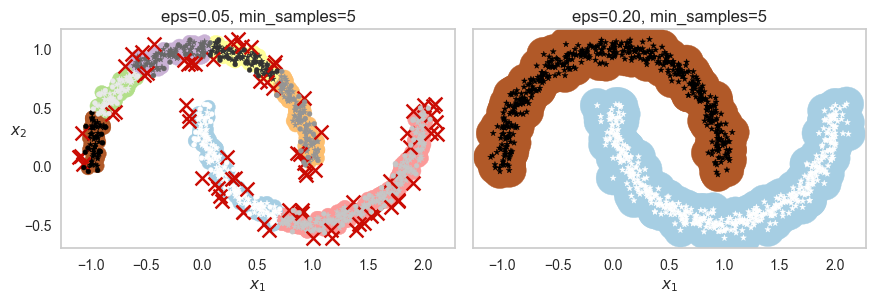

In [52]:
# extra code – this cell generates and saves Figure 9–14

def plot_dbscan(dbscan, X, size, show_xlabels=True, show_ylabels=True):
    core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_mask[dbscan.core_sample_indices_] = True
    anomalies_mask = dbscan.labels_ == -1
    non_core_mask = ~(core_mask | anomalies_mask)

    cores = dbscan.components_
    anomalies = X[anomalies_mask]
    non_cores = X[non_core_mask]
    
    plt.scatter(cores[:, 0], cores[:, 1],
                c=dbscan.labels_[core_mask], marker='o', s=size, cmap="Paired")
    plt.scatter(cores[:, 0], cores[:, 1], marker='*', s=20,
                c=dbscan.labels_[core_mask])
    plt.scatter(anomalies[:, 0], anomalies[:, 1],
                c="r", marker="x", s=100)
    plt.scatter(non_cores[:, 0], non_cores[:, 1],
                c=dbscan.labels_[non_core_mask], marker=".")
    if show_xlabels:
        plt.xlabel("$x_1$")
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title(f"eps={dbscan.eps:.2f}, min_samples={dbscan.min_samples}")
    plt.grid()
    plt.gca().set_axisbelow(True)

dbscan2 = DBSCAN(eps=0.2)
dbscan2.fit(X)

plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_dbscan(dbscan, X, size=100)

plt.subplot(122)
plot_dbscan(dbscan2, X, size=600, show_ylabels=False)

save_fig("dbscan_plot")
plt.show()

eps=0.05的聚類在的左圖中表示，它識別出相當多的異常情況，外加 7 個不同的集群。 幸運的是，如果通過將 eps 增加到 0.2 來擴大每個observation的neighborhood，就會得到右側的聚類，這看起來很完美。 

繼續使用eps=0.2這個模型。

In [53]:
dbscan = dbscan2 

DBSCAN 沒有 predict() 方法。 換句話說，它無法預測新observation屬於哪個集群。 這個決定的基本原理是基於資料或任務的不同使用不同的其他算法更好，並且很容易訓練一個，例如 KNeighborsClassifier：

In [54]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=50)
knn.fit(dbscan.components_, dbscan.labels_[dbscan.core_sample_indices_])

KNeighborsClassifier(n_neighbors=50)

請注意，此時只在core instance上訓練分類器，但也可以選擇在所有observation上訓練，或者除了異常值之外的所有observation，這個選擇取決於最終任務。

In [55]:
X_new = np.array([[-0.5, 0], [0, 0.5], [1, -0.1], [2, 1]])
knn.predict(X_new)

array([1, 0, 1, 0], dtype=int64)

In [56]:
knn.predict_proba(X_new)

array([[0.18, 0.82],
       [1.  , 0.  ],
       [0.12, 0.88],
       [1.  , 0.  ]])

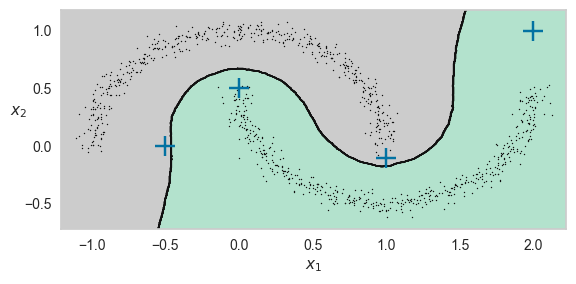

In [57]:
plt.figure(figsize=(6, 3))
plot_decision_boundaries(knn, X, show_centroids=False)
plt.scatter(X_new[:, 0], X_new[:, 1], c="b", marker="+", s=200, zorder=10)
save_fig("cluster_classification_plot")
plt.show()

由於訓練集中沒有異常值，分類器為每個observation總是選擇一個集群，即使該集群距離很遠。 然而，引入最大距離相當簡單，在此X_new中，遠離兩個集群的兩個observation應該被歸類為異常，可以使用 KNeighborsClassifier 的 kneighbors() 方法，給定K_new，它返回訓練集中 k 個最近鄰居的距離和其索引（兩個矩陣，每個矩陣有 k 列）：

In [59]:
y_dist, y_pred_idx = knn.kneighbors(X_new, n_neighbors=1)
y_pred = dbscan.labels_[dbscan.core_sample_indices_][y_pred_idx]
y_pred[y_dist > 0.2] = -1
y_pred.ravel()

array([-1,  0,  1, -1], dtype=int64)

簡而言之，DBSCAN 是一種非常簡單但功能強大的算法，能夠識別任意數量、任意形狀的聚類，對異常值穩健，並且只有兩個參數（eps 和 min_samples）。 但是，如果集群之間的密度差異很大，則可能無法正確捕獲所有集群。 此外，它的計算複雜度大約為 O(m^2*n)，使複雜度與實observation量接近線性關係，數據集大時要花較久時間。 

可以嘗試在 scikit-learn-contrib 中使用的 hierarchical DBSCAN(HDBSCAN)。 因為它通常比 DBSCAN 更擅長尋找不同密度的聚類。

# Gaussian Mixtures

高斯混合模型 (GMM) 是一種概率模型，它假設observation是從幾個參數未知的高斯分佈的混合中生成的。 從單個高斯分佈生成的所有observation形成一個通常看起來像橢圓體(ellipsoidal shape)的集群。 每個簇可以具有不同的橢圓體形狀、大小、密度和方向， 當你觀察一個observation時，你知道它是從一種高斯分佈生成的，但你不知道是哪一種，你也不知道這些分佈的參數是什麼。

generate the same dataset

In [63]:
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

In [61]:
from sklearn.mixture import GaussianMixture

In [71]:
gm = GaussianMixture(n_components=3, n_init=10, random_state=42)
gm.fit(X)

GaussianMixture(n_components=3, n_init=10, random_state=42)

Let's look at the parameters that the EM algorithm estimated:

In [72]:
gm.weights_

array([0.39025715, 0.40007391, 0.20966893])

In [65]:
gm.means_

array([[-0.74503074,  0.55807632],
       [ 0.4950664 ,  0.25373843],
       [ 1.73110722, -0.06902321]])

In [66]:
gm.covariances_

array([[[ 0.05459987,  0.06280737],
        [ 0.06280737,  0.09028234]],

       [[ 0.16337036, -0.09692064],
        [-0.09692064,  0.28734238]],

       [[ 0.06102278,  0.06561808],
        [ 0.06561808,  0.08773031]]])

用於生成數據的權重約為 0.4、0.4 和 0.2，同樣，均值和covariance矩陣與算法找到的值非常接近。

這個算法依賴於ExpectationMaximization（EM）算法，它與K-Means算法有很多相似之處：它也是隨機初始化簇參數，然後重複兩個步驟直到收斂，首先將observation分配給簇(this is called the expectation step) 然後更新集群（this is called the maximization step）。

可以將 EM 視為 KMeans 的延伸，它不僅可以找到聚類中心（μ(1) 到 μ(k)），還可以找到它們的大小、形狀和方向(Σ(1) 到 Σ(k))，以及它們的相對權重（φ(1) 到 φ(k)）。與 KMeans 不同，EM 使用soft cluster assignments而不是hard assignments：對於expectation step中的每個observation，算法估計它屬於每個集群的概率（基於當前的集群參數）。

不幸的是，就像 K-Means 一樣，EM 最終可能會收斂到較差的解決方案，因此它需要運行多次，只保留最佳解決方案。 這就是將 n_init 設置為 10 的原因。注意：默認情況下 n_init 僅設置為 1。

可以檢查算法是否收斂以及迭代次數：

In [73]:
gm.converged_

True

In [74]:
gm.n_iter_

4

now that you have an estimate of the location, size, shape, orientation and relative weight of each cluster, the model can easily assign each observation to the most likely cluster (hard clustering) or estimate the probability that it belongs to a particular cluster (soft clustering). For this, just use the predict() method for hard clustering, or the predict_proba() method for soft clustering:

In [75]:
gm.predict(X)

array([0, 0, 1, ..., 2, 2, 2], dtype=int64)

In [76]:
gm.predict_proba(X).round(3)

array([[0.977, 0.   , 0.023],
       [0.983, 0.001, 0.016],
       [0.   , 1.   , 0.   ],
       ...,
       [0.   , 0.   , 1.   ],
       [0.   , 0.   , 1.   ],
       [0.   , 0.   , 1.   ]])

GMM is a generative model, meaning you can actually sample new instances from it (note that they are ordered by cluster index):

In [77]:
X_new, y_new = gm.sample(6)
X_new

array([[-0.86944074, -0.32767626],
       [ 0.29836051,  0.28297011],
       [-2.8014927 , -0.09047309],
       [ 3.98203732,  1.49951491],
       [ 3.81677148,  0.53095244],
       [ 2.84104923, -0.73858639]])

In [78]:
y_new

array([0, 0, 1, 2, 2, 2])

也可以估計模型在任何給定位置的密度。 這是使用 score_samples() 方法實現的：對於給定的每個observatio，該方法估計該位置的概率密度函數 (PDF) 的對數(log PDF)。 分數越大，密度越高：

In [79]:
gm.score_samples(X).round(2)

array([-2.61, -3.57, -3.33, ..., -3.51, -4.4 , -3.81])

如果算這些分數的指數，將獲得給定observation位置處的 PDF 值。 這些不是概率，而是概率密度：它們可以取任何正值，而不僅僅是介於 0 和 1 之間。要估計一個observation落入特定區域的概率，必須對該區域的 PDF 進行積分(如果在observation可能的位置的整個空間上這樣做，結果將是 1)。

Figure shows the cluster means, the decision boundaries (dashed lines), and the density contours(密度等值線) of this model:

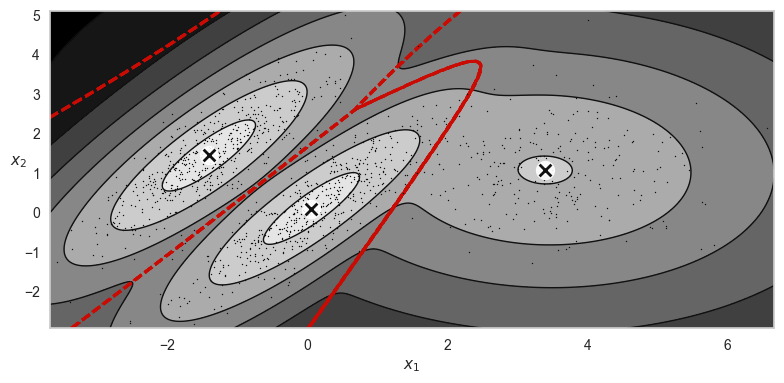

In [80]:
from matplotlib.colors import LogNorm

def plot_gaussian_mixture(clusterer, X, resolution=1000, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z,
                 norm=LogNorm(vmin=1.0, vmax=30.0),
                 levels=np.logspace(0, 2, 12))
    plt.contour(xx, yy, Z,
                norm=LogNorm(vmin=1.0, vmax=30.0),
                levels=np.logspace(0, 2, 12),
                linewidths=1, colors='k')

    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z,
                linewidths=2, colors='r', linestyles='dashed')
    
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    plot_centroids(clusterer.means_, clusterer.weights_)

    plt.xlabel("$x_1$")
    if show_ylabels:
        plt.ylabel("$x_2$", rotation=0)
    else:
        plt.tick_params(labelleft=False)

plt.figure(figsize=(8, 4))

plot_gaussian_mixture(gm, X)

save_fig("gaussian_mixtures_plot")
plt.show()

 該算法顯然找到了一個極好的解決方案。 當然，這也是因為通過使用一組二維高斯分佈生成的數據（不幸的是，現實生活中的數據並不總是那麼高斯和這麼低維）來簡化它的任務，且還為算法提供了正確的簇數。 
 
 當有很多維度、很多集群或很少observation時，EM 可能很難收斂到最優解。 可能需要通過限制算法必須學習的參數數量來降低任務的難度：一種方法是限制集群可以具有的形狀和方向的範圍。 這可以通過對covariance矩陣施加約束來實現。 為此，只需將 covariance_type 超參數設置為以下值之一： 
 
 * “spherical”：所有簇都必須是球形的，但它們可以具有不同的直徑（即不同的variance）。 
 
 * “diag”：集群可以呈現任何大小的任何橢圓體形狀，但橢圓體的軸必須平行於坐標軸（即，covariance矩陣必須是對角線的）。 
 
 * “tied”：所有簇必須具有相同的橢圓形狀、大小和方向（即，所有簇共享相同的covariance矩陣）。 
 
 * 默認情況下，covariance_type 等於“full”，這意味著每個聚類可以採用任何形狀、大小和方向（它有自己的不受約束的covariance矩陣）。 
 
 下繪製了當 cova riance_type 設置為“tied”或“spherical”時 EM 算法找到的解

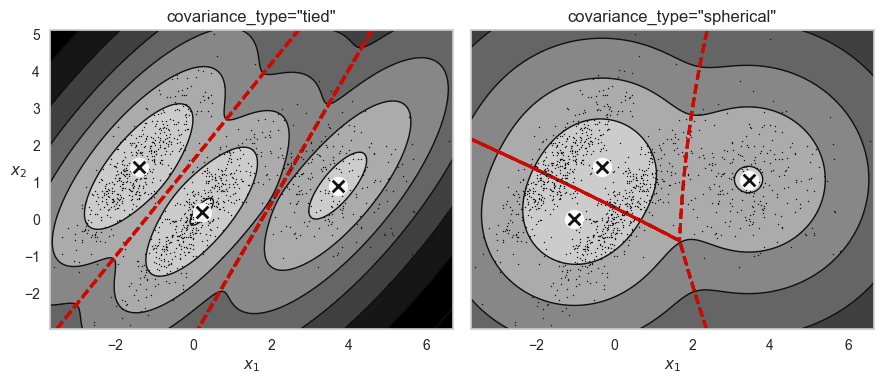

In [81]:
gm_full = GaussianMixture(n_components=3, n_init=10,
                          covariance_type="full", random_state=42)
gm_tied = GaussianMixture(n_components=3, n_init=10,
                          covariance_type="tied", random_state=42)
gm_spherical = GaussianMixture(n_components=3, n_init=10,
                               covariance_type="spherical", random_state=42)
gm_diag = GaussianMixture(n_components=3, n_init=10,
                          covariance_type="diag", random_state=42)
gm_full.fit(X)
gm_tied.fit(X)
gm_spherical.fit(X)
gm_diag.fit(X)

def compare_gaussian_mixtures(gm1, gm2, X):
    plt.figure(figsize=(9, 4))

    plt.subplot(121)
    plot_gaussian_mixture(gm1, X)
    plt.title(f'covariance_type="{gm1.covariance_type}"')

    plt.subplot(122)
    plot_gaussian_mixture(gm2, X, show_ylabels=False)
    plt.title(f'covariance_type="{gm2.covariance_type}"')

compare_gaussian_mixtures(gm_tied, gm_spherical, X)

save_fig("covariance_type_plot")
plt.show()

訓練 GaussianMixture 模型的計算複雜度取決於實例數 m、維數 n、聚類數 k 以及對covariance矩陣的約束。 如果covariance_type是“spherical”或“diag”，則為O(kmn)，此時假設數據具有聚類結構。如果covariance_type為“tied”或“full”，則為O(kmn^2 + kn^3)，因此不會擴展到大量特徵。

## Using Gaussian Mixtures for Anomaly Detection

使用高斯混合模型進行異常檢測非常簡單，任何位於低密度區域的observation都可以被視為異常。 必須定義要使用的密度閾值。 例如，在一家試圖檢測缺陷產品的製造公司中，缺陷產品的比率通常是已知的。 假設它等於2%，那麼可以將密度閾值設置為"導致 2% 的observation低於該閾值密度的區域"的值。 如果注意到有太多false positive（即被標記為有缺陷的完美產品），可以降低閾值。 相反，如果你太多的false negative（即係統沒有標記為有缺陷的有缺陷產品），可以增加閾值。 

下面是如何使用第 2個百分位數的最低密度作為閾值來識別異常值（即，大約 2% 的observation將被標記為異常）：

In [86]:
densities = gm.score_samples(X)
densities

array([-2.60768954, -3.57110232, -3.32987086, ..., -3.51347241,
       -4.39798588, -3.80746532])

In [87]:
density_threshold = np.percentile(densities, 2)
anomalies = X[densities < density_threshold]

In [89]:
anomalies

array([[ 0.74219223, -1.00445177],
       [-2.53940854, -2.76549965],
       [-1.74680316, -0.78385111],
       [ 0.53903026,  5.00244257],
       [-0.51480414, -2.16270124],
       [-1.79651788, -0.97031471],
       [-3.39408574, -2.28378778],
       [ 1.58082729,  4.20122873],
       [-2.06317379,  2.2670332 ],
       [-2.54004484, -2.8290338 ],
       [-1.93037427, -1.19447352],
       [-0.27124433, -1.86750177],
       [-1.93315582,  2.49030105],
       [ 5.80546094, -0.85297906],
       [ 5.68060531,  0.20598784],
       [ 3.55103259,  3.47752824],
       [ 5.5515503 ,  2.76962697],
       [ 4.00585006,  4.86701762],
       [ 3.22614554,  3.73445529],
       [ 5.61295857,  2.04675139],
       [ 5.62383575, -0.93780167],
       [ 2.30754386, -1.02494605],
       [ 6.56968319,  2.13386104],
       [ 3.21575068, -1.28763504],
       [ 4.07765947,  3.20474175]])

<function matplotlib.pyplot.show(close=None, block=None)>

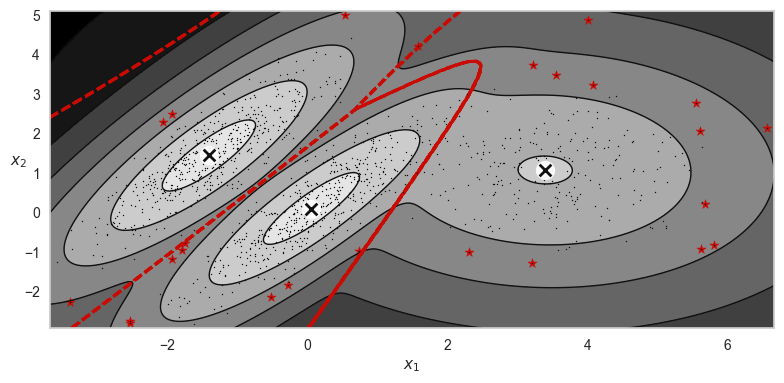

In [90]:
# extra code – this cell generates and saves Figure 9–18

plt.figure(figsize=(8, 4))

plot_gaussian_mixture(gm, X)
plt.scatter(anomalies[:, 0], anomalies[:, 1], color='r', marker='*')
plt.ylim(top=5.1)

save_fig("mixture_anomaly_detection_plot")
plt.show

## Selecting the Number of Clusters

使用 K-Means，可以使用inertia或silhouette score來選擇適當數量的聚類，但是對於高斯混合，無法使用這些指標，因為當聚類不是球形或具有不同大小時它們不可靠。 相反，可以嘗試找到最小化理論信息標準(minimizes a theoretical information criterion) 的模型，Bayesian information criterion (BIC) 或 Akaike information criterion (AIC)。

BIC 和 AIC 都會懲罰具有更多參數要學習的模型（例如，更多的集群），並獎勵能夠很好地擬合數據的模型。 他們通常最終會選擇相同的模型，但當它們不同時，BIC 選擇的模型往往比 AIC 選擇的模型更簡單（參數更少），但它不太擬合數據（這尤其是對於大的數據集）。

要計算 BIC 和 AIC，只需調用 bic() 或 aic()

In [91]:
gm.bic(X)

8189.747000497186

In [92]:
gm.aic(X)

8102.521720382148

下圖顯示了不同數量的簇 k 的 BIC。 當 k=3 時，BIC 和 AIC 均最低，因此它很可能是最佳選擇。 請注意，我們還可以搜索 covariance_type 超參數的最佳值。 例如，如果它是“spherical”而不是“full”，那麼模型需要學習的參數就會少得多，但它也不能很好地擬合數據。

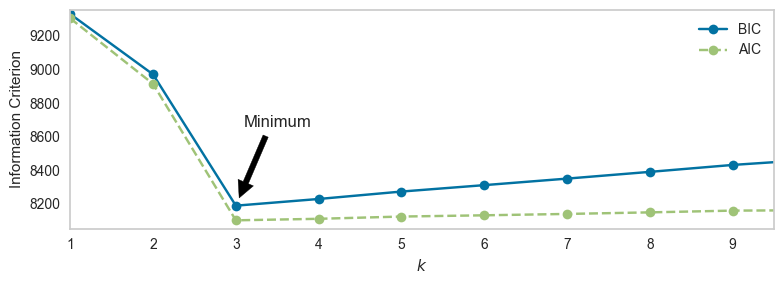

In [93]:
gms_per_k = [GaussianMixture(n_components=k, n_init=10, random_state=42).fit(X)
             for k in range(1, 11)]
bics = [model.bic(X) for model in gms_per_k]
aics = [model.aic(X) for model in gms_per_k]

plt.figure(figsize=(8, 3))
plt.plot(range(1, 11), bics, "bo-", label="BIC")
plt.plot(range(1, 11), aics, "go--", label="AIC")
plt.xlabel("$k$")
plt.ylabel("Information Criterion")
plt.axis([1, 9.5, min(aics) - 50, max(aics) + 50])
plt.annotate("", xy=(3, bics[2]), xytext=(3.4, 8650),
             arrowprops=dict(facecolor='black', shrink=0.1))
plt.text(3.5, 8660, "Minimum", horizontalalignment="center")
plt.legend()
plt.grid()
save_fig("aic_bic_vs_k_plot")
plt.show()


# Bayesian Gaussian Mixture Models

與其手動搜索最佳集群數量，不如使用 BayesianGaussianMixture，能夠為不必要的集群賦予等於（或接近）零的權重。 只需將聚類數 n_components 設置為有充分理由相信大於最佳聚類數的值（這假定對手頭的問題有一些最低限度的了解），算法將自動消除不必要的聚類。

In [94]:
from sklearn.mixture import BayesianGaussianMixture

In [95]:
bgm = BayesianGaussianMixture(n_components=10, n_init=10, random_state=42)
bgm.fit(X)
bgm.weights_.round(2)

array([0.4 , 0.21, 0.4 , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

算法自動檢測到只需要3個component！

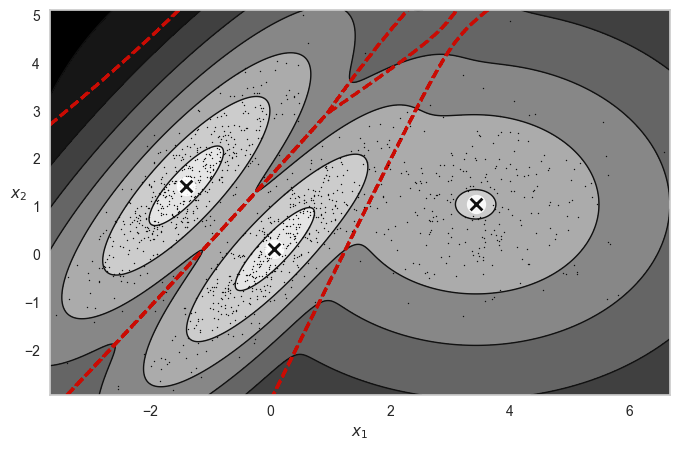

In [96]:
# extra code – this figure is almost identical to Figure 9–16
plt.figure(figsize=(8, 5))
plot_gaussian_mixture(bgm, X)
plt.show()